In [1]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from betatcvae import BetaTCVAE, compile_tc_vae, tc_weights, extract_latent_dimensions
from optimize_utils_tcvae import get_optimizer_tc

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [2]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [3]:
# Load the best hyperparameters
study_name = "BetaTCVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [4]:
#Initialize the model and optimizer
model = BetaTCVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = get_optimizer_tc(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_tc_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

Epoch 1, Train Loss: 895.2127550722947, Val Loss: 693.2481825086805, Test Loss: 698.7668931749132
Epoch 2, Train Loss: 341.84443632666745, Val Loss: 127.42891777886285, Test Loss: 129.0120349460178
Epoch 3, Train Loss: 69.62189476810285, Val Loss: 44.29179000854492, Test Loss: 45.24481116400825
Epoch 4, Train Loss: 35.454774497871966, Val Loss: 32.318345387776695, Test Loss: 33.533158196343315
Epoch 5, Train Loss: 30.750722537823577, Val Loss: 29.352020687527126, Test Loss: 31.069935268825954
Epoch 6, Train Loss: 29.07416345397038, Val Loss: 27.982595019870335, Test Loss: 29.906410217285156
Epoch 7, Train Loss: 27.803611641499533, Val Loss: 26.812593036227756, Test Loss: 27.84471109178331
Epoch 8, Train Loss: 26.975777059526585, Val Loss: 26.231563991970486, Test Loss: 27.701040267944336
Epoch 9, Train Loss: 26.740026035593516, Val Loss: 26.55980152553982, Test Loss: 28.027620315551758
Epoch 10, Train Loss: 26.421440557223647, Val Loss: 26.603411568535698, Test Loss: 27.70679473876953


In [5]:
# Save the model
model_path = pathlib.Path("results/best_tc_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [6]:
# Save training history
history = {
    'loss': train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

# Convert the history dictionary into a DataFrame
history_df = pd.DataFrame(history)

# Define the path for the CSV file
history_path = pathlib.Path("results/tc_training_history.csv")

# Save the DataFrame to a CSV file
history_df.to_csv(history_path, index=False)

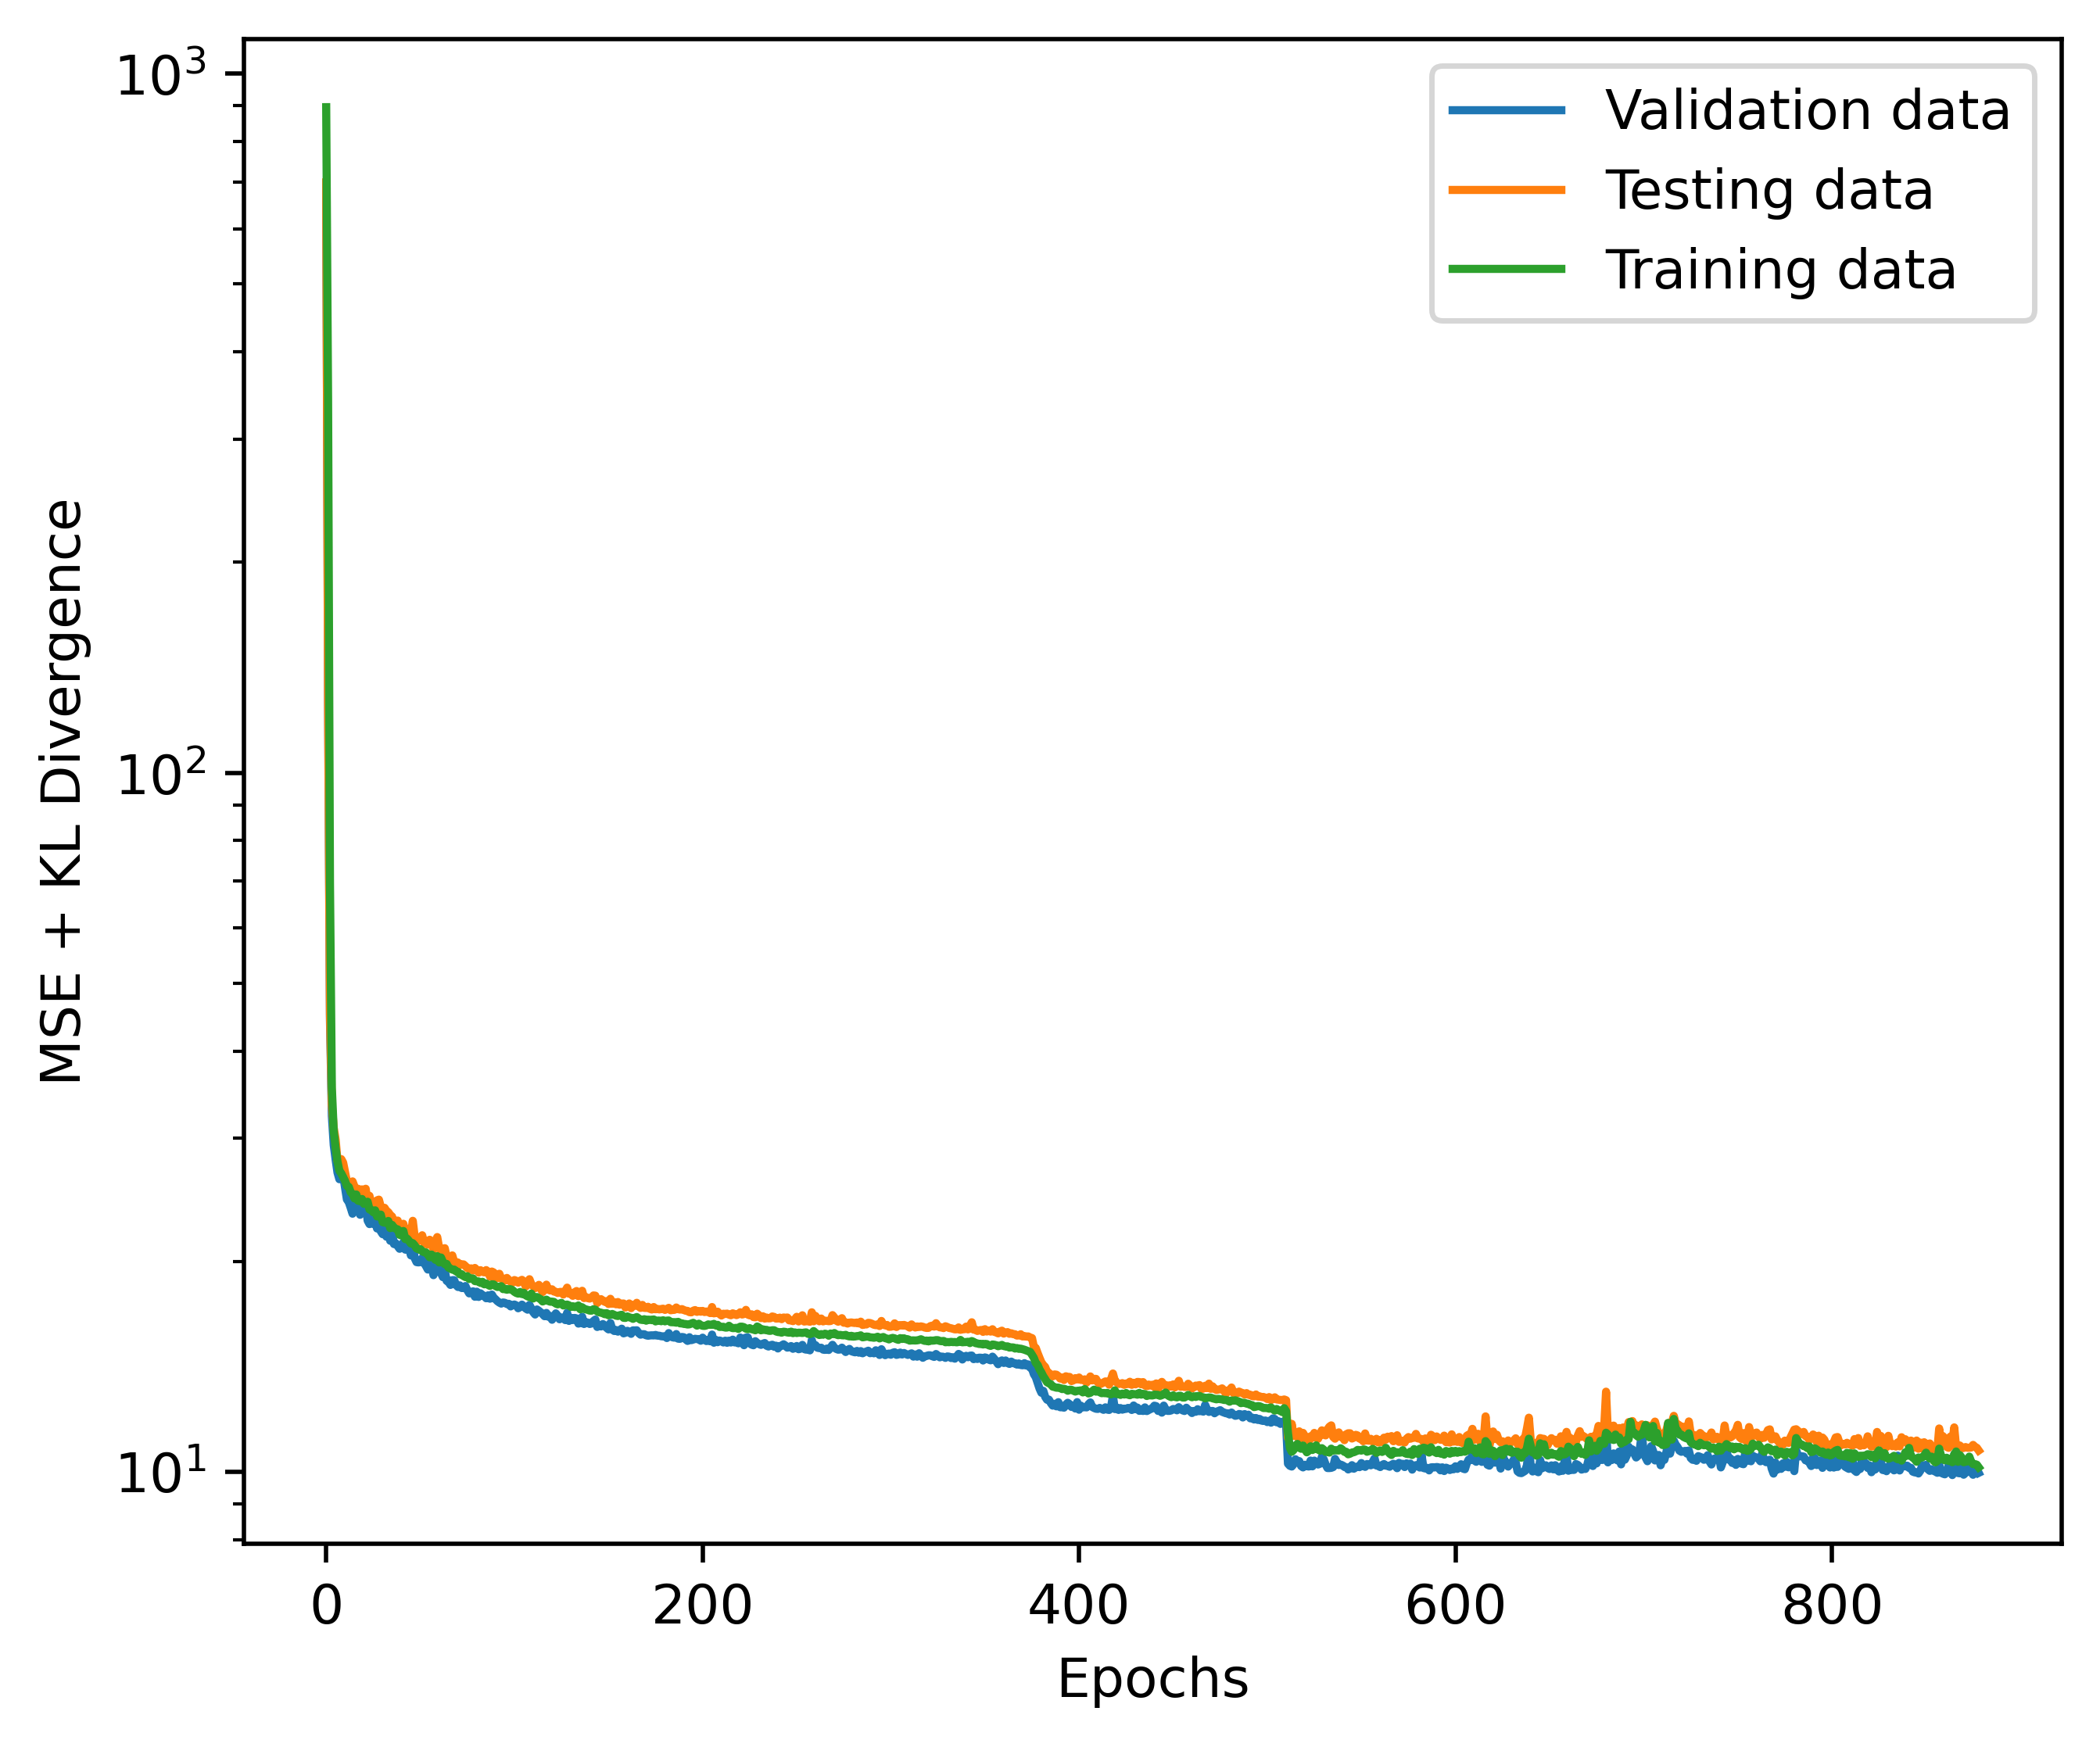

In [7]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

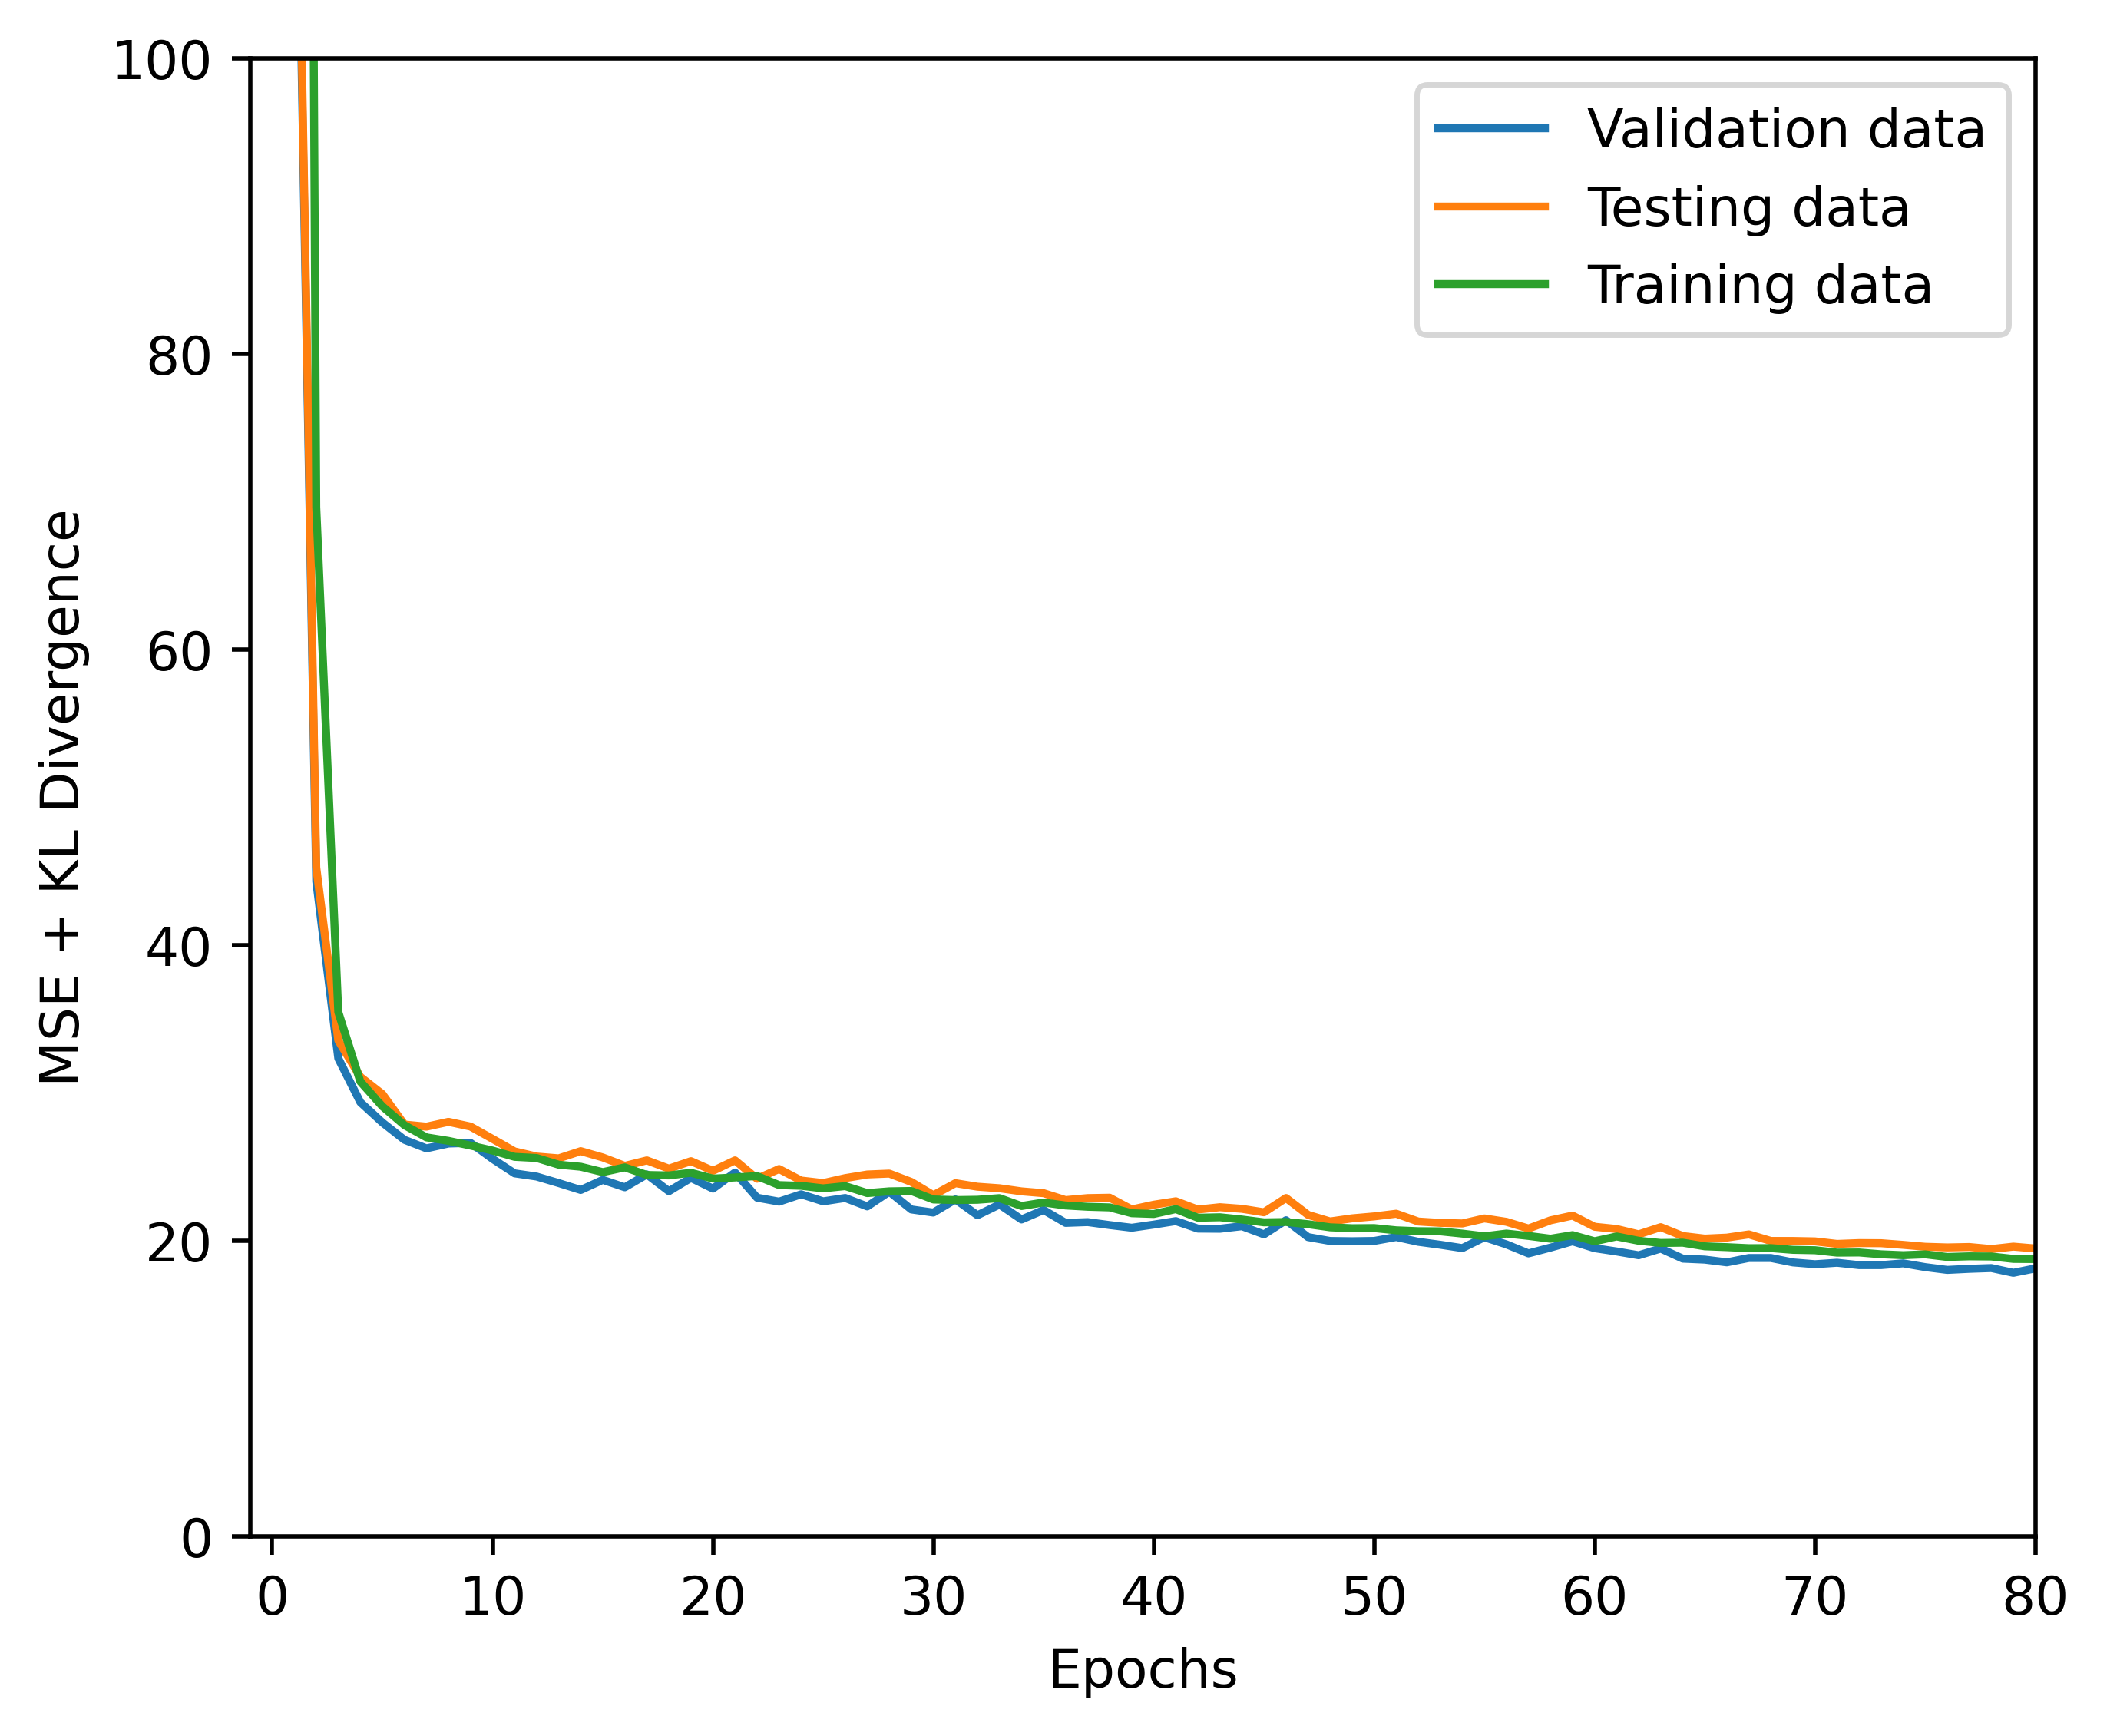

In [8]:
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-1,80)
plt.ylim(0,100)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [9]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train", drop_columns=False
)

train_df[["AgeCategory", "Sex"]] = train_df.age_and_sex.str.split(
    pat="_", expand=True
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_parquet(
    "../0.data-download/data/CRISPR_gene_dictionary.parquet"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
path = "./results/weight_matrix_gsea_tc.parquet"
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = tc_weights(model, train_data, path)

In [10]:
# Extract the latent space dimensions
metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.parquet")
metadata = pd.read_parquet(metadata_df_dir)

train_and_test_subbed_dir = pathlib.Path("../0.data-download/data/train_and_test_subbed.parquet")
train_and_test_subbed = pd.read_parquet(train_and_test_subbed_dir)


# Convert DataFrame to NumPy and then Tensor
train_test_array = train_and_test_subbed.to_numpy()
train_test_tensor = torch.tensor(train_test_array, dtype=torch.float32)

#Create TensorDataset and DataLoader
tensor_dataset = TensorDataset(train_test_tensor)
train_and_test_subbed_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=False)

path = "./results/tc_latent_df.parquet"

latent_df = extract_latent_dimensions(model, train_and_test_subbed_loader, metadata, path)
print(latent_df.head())

      ModelID         0         1         2         3         4         5  \
0  ACH-000748  0.092405 -0.010738  0.023871  0.031923 -0.047092  0.063592   
1  ACH-000645  0.073446 -0.015453  0.031180  0.031931 -0.045990  0.097900   
2  ACH-001301  0.090064 -0.012110  0.021124  0.034129 -0.045762  0.084990   
3  ACH-000361  0.096737 -0.010758  0.027304  0.035545 -0.050358  0.072394   
4  ACH-000325  0.072972  0.007525  0.004274  0.007806 -0.035361  0.078713   

          6         7         8  ...       183       184       185       186  \
0  0.061442  0.007988 -0.032185  ... -0.097966 -0.101726  0.001914  0.089119   
1  0.056464  0.022123 -0.047070  ... -0.074746 -0.112549  0.015376  0.107483   
2  0.062151  0.017229 -0.039084  ... -0.083354 -0.103958  0.000217  0.094157   
3  0.055757  0.020147 -0.034915  ... -0.076168 -0.112492  0.001263  0.076512   
4  0.064441  0.038166 -0.039378  ... -0.089860 -0.121283 -0.002529  0.086065   

        187       188       189       190       191     